In [47]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import GEOparse
import networkx as nx
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from gseapy import enrichr, barplot, enrichment_map

# Show all columns
pd.set_option('display.max_columns', None)

In [2]:
PATH_27K = Path("data/arrays_27k")
PATH_450K = Path("data/arrays_450k")

In [3]:
len(list(PATH_27K.glob('*.npy'))), len(list(PATH_450K.glob('*.npy')))

(4013, 984)

In [4]:
geo_samples = pd.read_csv("data/geo_samples.csv")
geo_samples['sex'] = geo_samples['sex'].map({'male': 'male', 'female': 'female', 'f': 'female', 'm': 'male'})
geo_samples.loc[geo_samples['disease'] == 'Hepatocellular carcinoma (HCC)', 'disease'] = 'cancer'
geo_samples

GSE      Sample     sex  age tissue  disease platform
0     GSE15745   GSM401538    male   20  brain  healthy      27k
1     GSE15745   GSM401539    male   44  brain  healthy      27k
2     GSE15745   GSM401540    male   68  brain  healthy      27k
3     GSE15745   GSM401541    male   38  brain  healthy      27k
4     GSE15745   GSM401542    male   66  brain  healthy      27k
...        ...         ...     ...  ...    ...      ...      ...
4721  GSE42861  GSM1052209  female   63  blood  healthy     450k
4722  GSE42861  GSM1052210  female   63  blood  healthy     450k
4723  GSE42861  GSM1052211  female   46  blood  healthy     450k
4724  GSE42861  GSM1052212  female   64  blood  healthy     450k
4725  GSE42861  GSM1052213  female   36  blood  healthy     450k

[4726 rows x 7 columns]

In [5]:
geo_samples['platform'].value_counts()

platform
27k     3730
450k     996
Name: count, dtype: int64

In [6]:
geo_samples_cells = pd.read_csv("data/geo_cell_samples.csv")
geo_samples_cells

GSE     Sample cell_type platform
0    GSE30090  GSM744663       ESC      27k
1    GSE30090  GSM744664       ESC      27k
2    GSE30090  GSM744665       ESC      27k
3    GSE30090  GSM744666       ESC      27k
4    GSE30090  GSM744667       ESC      27k
..        ...        ...       ...      ...
231  GSE31848  GSM867991      iPSC     450k
232  GSE31848  GSM867992      iPSC     450k
233  GSE31848  GSM867993      iPSC     450k
234  GSE31848  GSM867994      iPSC     450k
235  GSE31848  GSM867995      iPSC     450k

[236 rows x 4 columns]

In [7]:
geo_samples_cells['platform'].value_counts()

platform
27k     188
450k     48
Name: count, dtype: int64

In [8]:
CPGS_27K_META_PATH = Path("data/cpgs_27k_meta.csv")

if not CPGS_27K_META_PATH.exists():
    gse = GEOparse.get_GEO('GSE17448', destdir='./data/', silent=True)
    cpgs_27k_meta = gse.gpls['GPL8490'].table.sort_values('ID')
    cpgs_27k_meta.to_csv(CPGS_27K_META_PATH, index=False)
else:
    cpgs_27k_meta = pd.read_csv(CPGS_27K_META_PATH)

# Standard definition of promoter region
# TSS — Transcription Start Site
cpgs_27k_meta['TSS_Distance_No_Abs'] = cpgs_27k_meta['MapInfo'] - cpgs_27k_meta['TSS_Coordinate']
cpgs_27k_meta['in_promoter'] = (
    (cpgs_27k_meta['TSS_Distance_No_Abs'] >= -1500)
    & (cpgs_27k_meta['TSS_Distance_No_Abs'] <= 200)
    )

cpgs_27k_meta

ID        Name IlmnStrand  AddressA_ID  \
0      cg00000292  cg00000292        TOP       990370   
1      cg00002426  cg00002426        TOP      6580397   
2      cg00003994  cg00003994        TOP      7150184   
3      cg00005847  cg00005847        BOT      4850717   
4      cg00006414  cg00006414        BOT      6980731   
...           ...         ...        ...          ...   
27573  cg27657283  cg27657283        TOP       510452   
27574  cg27661264  cg27661264        BOT      7210519   
27575  cg27662379  cg27662379        BOT        60167   
27576  cg27662877  cg27662877        TOP      2120673   
27577  cg27665659  cg27665659        TOP       360474   

                                        AlleleA_ProbeSeq  AddressB_ID  \
0      AAACATTAATTACCAACCACTCTTCCAAAAAACACTTACCATTAAA...      6660678   
1      AATATAATAACATTACCTTACCCATCTTATAATCAAACCAAACAAA...      6100343   
2      AATAATAATAATACCCCCTATAATACTAACTAACAAACATACCCTC...      7150392   
3      TACTATAATACACCCTATATTTAAAACACTAAACTTACCCCATTAA...      1260113   
4      CTCAAAAACCAAACAAAACAAAACCCCAATACTAATCATTAATAAA...      4280093   
...                                                  ...          ...   
27573  AAACCAAAAATTCCTCTAACTACAACTTAAATACCCATAATCTTCC...      7510537   
27574  TAACTAATTTAAAATCTTTCTCCTCACTTCTCCACTAACCAAAAAA...      6840035   
27575  CACTAAACAACCATTCATTAAACAAAAACTAATAACACAAAATAAC...      4570626   
27576  ACCTATACAAAATCCAATCTTATAAAAACAACAAACTAAACAACAA...      3180717   
27577  AACCAAACTCCTAAAAACTACAATCAAAAACCTAATTACCATAATT...      4040465   

                                        AlleleB_ProbeSeq  GenomeBuild Chr  \
0      AAACATTAATTACCAACCGCTCTTCCAAAAAACACTTACCATTAAA...           36  16   
1      AATATAATAACATTACCTTACCCGTCTTATAATCAAACCAAACGAA...           36   3   
2      AATAATAATAATACCCCCTATAATACTAACTAACAAACATACCCTC...           36   7   
3      TACTATAATACACCCTATATTTAAAACACTAAACTTACCCCATTAA...           36   2   
4      CTCGAAAACCGAACAAAACAAAACCCCAATACTAATCGTTAATAAA...           36   7   
...                                                  ...          ...  ..   
27573  AAACCAAAAATTCCTCTAACTACAACTTAAATACCCATAATCTTCC...           36   1   
27574  TAACTAATTTAAAATCTTTCTCCTCGCTTCTCCGCTAACCAAAAAA...           36  20   
27575  CACTAAACAACCGTTCATTAAACAAAAACTAATAACACAAAATAAC...           36   3   
27576  ACCTATACAAAATCCAATCTTATAAAAACGACGAACTAAACAACGA...           36  18   
27577  GACCGAACTCCTAAAAACTACAATCAAAAACCTAATTACCATAATT...           36   7   

         MapInfo   Ploidy       Species       Source  SourceVersion  \
0       28797601  diploid  Homo sapiens  NCBI:RefSeq           36.1   
1       57718583  diploid  Homo sapiens  NCBI:RefSeq           36.1   
2       15692387  diploid  Homo sapiens  NCBI:RefSeq           36.1   
3      176737319  diploid  Homo sapiens  NCBI:RefSeq           36.1   
4      148453770  diploid  Homo sapiens  NCBI:RefSeq           36.1   
...          ...      ...           ...          ...            ...   
27573   43006110  diploid  Homo sapiens  NCBI:RefSeq           36.1   
27574   56861133  diploid  Homo sapiens  NCBI:RefSeq           36.1   
27575  129852443  diploid  Homo sapiens  NCBI:RefSeq           36.1   
27576   70110575  diploid  Homo sapiens  NCBI:RefSeq           36.1   
27577  100584315  diploid  Homo sapiens  NCBI:RefSeq           36.1   

      SourceStrand                                          SourceSeq  \
0              TOP  CGGCCTCAATGGTAAGTGTCCCTTGGAAGAGCGGCTGGTAATTAAT...   
1              TOP  CGCTCTCGTCTGGTTTGATCACAAGACGGGCAAGGTAATGTCACCA...   
2              BOT  GGTGGTGGTGGTGCCCCCTGTGATGCTGGCTGGCAAACATGCCCTC...   
3              BOT  TACTGTAATGCACCCTGTATTTAAGGCACTGGGCTTGCCCCATTAA...   
4              BOT  CTCGGAAACCGAGCAGGGCAAAACCCCAGTGCTGATCGTTAGTGGG...   
...            ...                                                ...   
27573          BOT  GGACCAAAGGTTCCTCTAACTGCAACTTGAGTGCCCATAATCTTCC...   
27574          BOT  TGACTGATTTGGAGTCTTTCTCCTCGCTTCTCCGCTGGCCAGAGAA...   
27575          TOP

In [9]:
cpgs_27k_meta['in_promoter'].value_counts()

in_promoter
True     18765
False     8813
Name: count, dtype: int64

In [10]:
CPGS_450K_META_PATH = Path("data/cpgs_450k_meta.csv")

if not CPGS_450K_META_PATH.exists():
    gse = GEOparse.get_GEO('GSE37066', destdir='./data/', silent=True)
    cpgs_450k_meta = gse.gpls['GPL13534'].table.sort_values('ID')
    cpgs_450k_meta.to_csv(CPGS_450K_META_PATH, index=False)
else:
    cpgs_450k_meta = pd.read_csv(CPGS_450K_META_PATH)
cpgs_450k_meta

/tmp/ipykernel_3491534/1595743125.py:8: DtypeWarning: Columns (15,36) have mixed types. Specify dtype option on import or set low_memory=False.
  cpgs_450k_meta = pd.read_csv(CPGS_450K_META_PATH)


ID        Name  AddressA_ID  \
0       cg00000029  cg00000029     14782418   
1       cg00000108  cg00000108     12709357   
2       cg00000109  cg00000109     59755374   
3       cg00000165  cg00000165     12637463   
4       cg00000236  cg00000236     12649348   
...            ...         ...          ...   
485572   rs9363764   rs9363764     36689314   
485573    rs939290    rs939290     70759471   
485574    rs951295    rs951295     11711409   
485575    rs966367    rs966367     16795360   
485576   rs9839873   rs9839873     32678396   

                                         AlleleA_ProbeSeq  AddressB_ID  \
0       AACTATACTAACRAAAAAATATCCAAAAAACACTAACRTATAAAAA...          NaN   
1       ATACAATAAAACAAACCTAAAATAATCCTAACTCCRCTATCATCCT...          NaN   
2       CAATACTAACAAACACATATACCCCCCCACAAATCTTAACTTCTAA...          NaN   
3       CAAAATCTATTAATACAATAACTTTTAATAAAACAACTAAAACACA...          NaN   
4       TATAACRTCATATTAAAAAAAACRATCTAACCCACCAATTTATACA...          NaN   
...                                                   ...          ...   
485572  TAACTCCCTACCACCTAAAACAAAACAATAATACACTAACTAATTT...          NaN   
485573  ATTTTATTTTCACTTTCCACAACCATAAACCCTTCCACCCAACATA...          NaN   
485574  AACAAACAAAAATACTACTCACAACTCTACTCATTAAAAAAACTCC...   39778441.0   
485575  ATAACTCCTTTAACTTTAAACACACATCTCTACACACAACCACATA...          NaN   
485576  AAAACCCTCTCTTTCTATCTCCCACTCTATATCACTCTACACATTT...          NaN   

                                         AlleleB_ProbeSeq  \
0                                                     NaN   
1                                                     NaN   
2                                                     NaN   
3                                                     NaN   
4                                                     NaN   
...                                                   ...   
485572                                                NaN   
485573                                                NaN   
485574  AACAAACAAAAATACTACTCACAACTCTACTCATTAAAAAAACTCC...   
485575                                                NaN   
485576                                                NaN   

       Infinium_Design_Type Next_Base Color_Channel  \
0                        II       NaN           NaN   
1                        II       NaN           NaN   
2                        II       NaN           NaN   
3                        II       NaN           NaN   
4                        II       NaN           NaN   
...                     ...       ...           ...   
485572                   II       NaN           NaN   
485573                   II       NaN           NaN   
485574                    I         C           Grn   
485575                   II       NaN           NaN   
485576                   II       NaN           NaN   

                                         Forward_Sequence  Genome_Build  CHR  \
0       TTTTTTAGATAAGGATATCCAGGCGATGAGGAAGTTTTACTTCTGG...          37.0   16   
1       TCCATTTTGAAGGAAAAAAATGAAGGCTCTGAAAGTGTAAATCGCT...          37.0    3   
2       GCCTTAGTCCTGAATGAGCCATTTCTCTAAGAAGTCCTGGCTTCTT...          37.0    3   
3       CTAAGTGCAGTCAGGATCTGTTAGTACAGTGGCTTTTGATGGAACA...          37.0    1   
4       CTCAGCGACAGTGTAGCGTCATGTTAGAGGAGACGATCTGACCCAC...          37.0    8   
...                                                   ...           ...  ...   
485572                                                NaN           NaN  NaN   
485573                                                NaN           NaN  NaN   
485574                                                NaN           NaN  NaN   
485575                                                NaN           NaN  NaN   
485576                                                NaN           NaN  NaN   

            MAPINFO                                          SourceSeq  \
0        53468112.0  GCTGTACTGACGAGAAAATGTCCAAAAGACACTGACGTGTGAAGGT...   
1        37459206.0  CGGCCAGGATGACAGCGGAGCCAGGATCACCCCAGGTC

In [11]:
cpgs_450k_meta['Regulatory_Feature_Group'].value_counts()

Regulatory_Feature_Group
Promoter_Associated                       91963
Unclassified_Cell_type_specific           36731
Unclassified                              30461
Promoter_Associated_Cell_type_specific     6127
Gene_Associated_Cell_type_specific         1963
NonGene_Associated                         1339
Gene_Associated                            1288
NonGene_Associated_Cell_type_specific       220
Name: count, dtype: int64

{"Crohn's disease": '.', 'autism': 'o', 'bipolar': 'v', 'cancer': '^', 'diabetes I': '<', 'diabetes II': '>', 'healthy': '8', 'rheumatoid arthritis': 's', 'shizophrenia': 'p'}


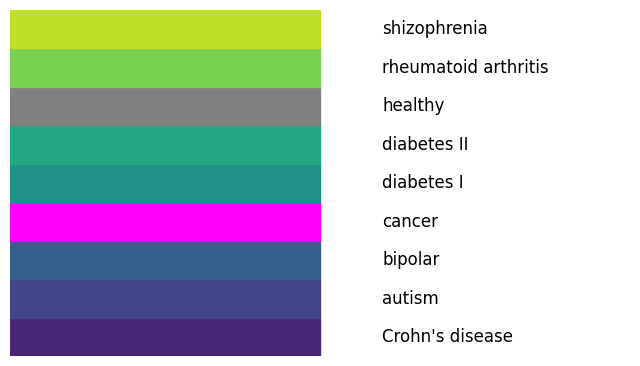

In [12]:
diseases_state = sorted(list(geo_samples['disease'].value_counts().index))
disease_map = geo_samples.set_index('Sample')['disease'].to_dict()

# Generate list of colors for each disease
colors = sns.color_palette("viridis", len(diseases_state))
colors_dict = dict(zip(diseases_state, colors))

colors_dict['healthy'] = 'grey'
colors_dict['cancer'] = 'magenta'

# Generate markers map using matplotlib.markers
markers_list = list(matplotlib.markers.MarkerStyle.filled_markers)[:len(diseases_state)]
markers_dict = dict(zip(diseases_state, markers_list))
print(markers_dict)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, len(diseases_state) * 0.5))

# Plot each color with a rectangle
for i, disease in enumerate(diseases_state):
    ax.add_patch(plt.Rectangle((0, i), 1, 1, color=colors_dict[disease]))
    ax.text(1.2, i + 0.5, disease, va='center', ha='left', fontsize=12)

# Set the axis limits
ax.set_xlim(0, 2)
ax.set_ylim(0, len(diseases_state))
ax.axis('off')  # Turn off the axis

# Display the plot
plt.show()

In [13]:
# Create age groups
AGE_GROUPS = {
    "0-5": (0, 5),
    "5-10": (5, 10),
    "10-18": (10, 18),
    "18-30": (18, 30),
    "30-50": (30, 50),
    "50-70": (50, 70),
    "70-120": (70, 120),
}

AGE_BINS = [x[0] for x in AGE_GROUPS.values()]
AGE_BINS.append(120)

geo_samples['age_group'] = pd.cut(geo_samples['age'], bins=AGE_BINS, labels=AGE_GROUPS.keys())
geo_samples['is_healthy'] = geo_samples['disease'] == 'healthy'

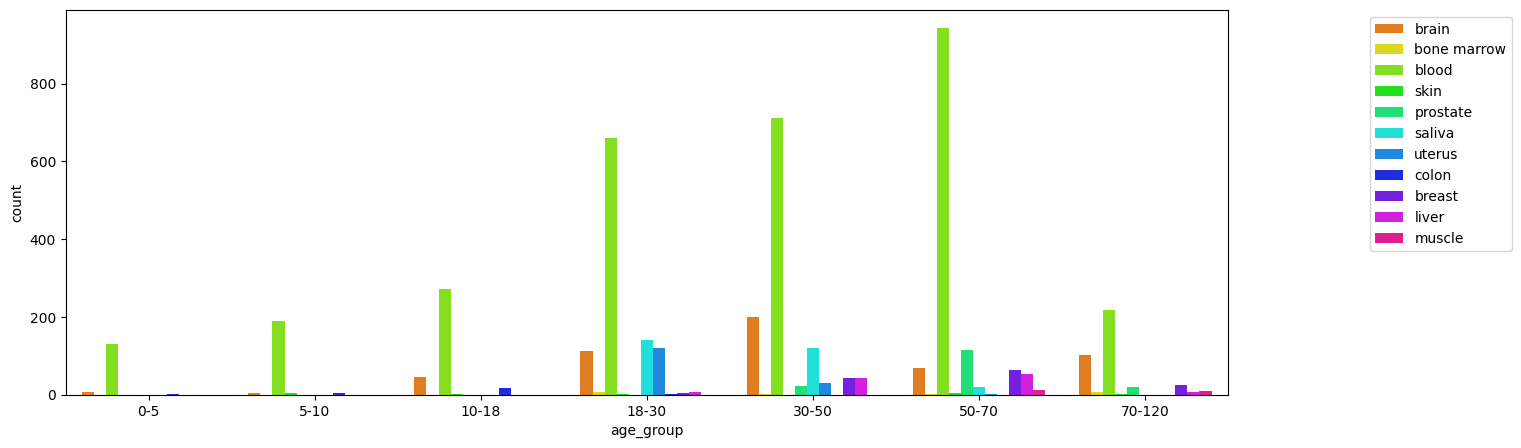

In [14]:
# Plot age groups distribution
plt.figure(figsize=(15, 5))
sns.countplot(data=geo_samples, x='age_group', order=AGE_GROUPS.keys(), hue='tissue', palette='hsv')

# Set legend outside of the plot
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))

plt.show()

In [15]:
geo_samples_27k = geo_samples[(geo_samples['platform'] == '27k') & (geo_samples['disease'] == 'healthy')]
geo_samples_27k_unhealthy = geo_samples[(geo_samples['platform'] == '27k') & (geo_samples['disease'] != 'healthy')]
geo_samples_age_map_27k = geo_samples_27k.set_index("Sample")["age"].to_dict()
geo_samples_age_map_27k_unhealthy = geo_samples_27k_unhealthy.set_index("Sample")["age"].to_dict()

geo_samples_450k = geo_samples[(geo_samples['platform'] == '450k') & (geo_samples['disease'] == 'healthy')]
geo_samples_450k_unhealthy = geo_samples[(geo_samples['platform'] == '450k') & (geo_samples['disease'] != 'healthy')]
geo_samples_age_map_450k = geo_samples_450k.set_index("Sample")["age"].to_dict()
geo_samples_age_map_450k_unhealthy = geo_samples_450k_unhealthy.set_index("Sample")["age"].to_dict()

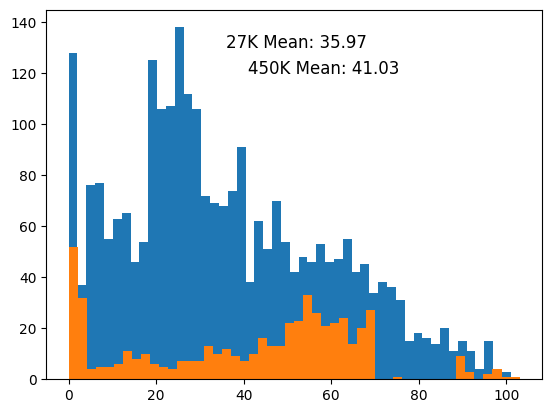

In [16]:
geo_samples_27k['age'].hist(bins=50)
plt.text(geo_samples_27k['age'].mean(), 130, f"27K Mean: {geo_samples_27k['age'].mean():.2f}", fontsize=12)
geo_samples_450k['age'].hist(bins=50)
plt.text(geo_samples_450k['age'].mean(), 120, f"450K Mean: {geo_samples_450k['age'].mean():.2f}", fontsize=12)
plt.grid(False)
plt.show()

In [17]:
def load_samples(directory: Path, sample_to_age_map: dict):
    samples = []
    rows = []
    ages = []

    for file_path in directory.glob("*.npy"):
        sample = file_path.stem
        age = sample_to_age_map.get(sample)
        if age is None:
            continue

        row = np.load(file_path)
        if np.all(np.isnan(row)):
            continue
        row = np.nan_to_num(row, nan=np.nanmean(row))
        
        # Normalize the data between 0 and 1
        row = (row - np.nanmin(row)) / (np.nanmax(row) - np.nanmin(row))

        samples.append(sample)
        rows.append(row)
        ages.append(age)
    rows = np.array(rows)
    ages = np.array(ages)
    return samples, rows, ages

In [18]:
def load_samples_cells(directory: Path):
    samples = []
    rows = []

    for file_path in directory.glob("*.npy"):
        sample = file_path.stem

        row = np.load(file_path)
        if np.all(np.isnan(row)):
            continue
        row = np.nan_to_num(row, nan=np.nanmean(row))
        
        # Normalize the data between 0 and 1
        row = (row - np.nanmin(row)) / (np.nanmax(row) - np.nanmin(row))

        samples.append(sample)
        rows.append(row)
    rows = np.array(rows)

    return samples, rows

In [19]:
def train_elastic_net(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = ElasticNet(alpha=0.01, l1_ratio=0.05, max_iter=2000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    return model, y_test, y_pred

def plot_model_resuts(y_test, y_pred, title = None):
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Plot the predicted vs actual ages
    plt.figure(figsize=(6, 6), dpi=200)
    plt.scatter(
        y_test,
        y_pred,
        alpha=0.5,
        color=colors_dict['healthy'],
        edgecolors='black',
        linewidths=0.5
    )
    plt.plot([0, 100], [0, 100], color="red", linestyle="--")
    if title:
        plt.title(title)
    plt.xlabel("Actual Age")
    plt.ylabel("Predicted Age")

    # Add the MAE and R2 score
    plt.text(10, 90, f"MAE: {mae:.2f}", fontsize=12)
    plt.text(10, 80, f"R2: {r2:.2f}", fontsize=12)

    plt.show()


def save_model(model, model_path):
   # Save both coefficients and intercept
    np.savez(model_path, coef=model.coef_, intercept=model.intercept_)


def save_model_eval(model_path, y_test, y_pred):
    # Save as a CSV file
    results = pd.DataFrame({
        "y_test": y_test,
        "y_pred": y_pred
    })
    results.to_csv(model_path.with_suffix(".csv"), index=False)


def load_model(model_path):
    # Load coefficients and intercept
    data = np.load(model_path)
    model = ElasticNet(alpha=0.01, l1_ratio=0.05, max_iter=2000)
    model.coef_ = data['coef']
    model.intercept_ = data['intercept']
    return model


def load_model_eval(model_path):
    results = pd.read_csv(model_path.with_suffix(".csv"))
    return results["y_test"].values, results["y_pred"].values


MODELS_PATH = Path("models")
MODELS_PATH.mkdir(exist_ok=True)

# 27K Model

## Train the model

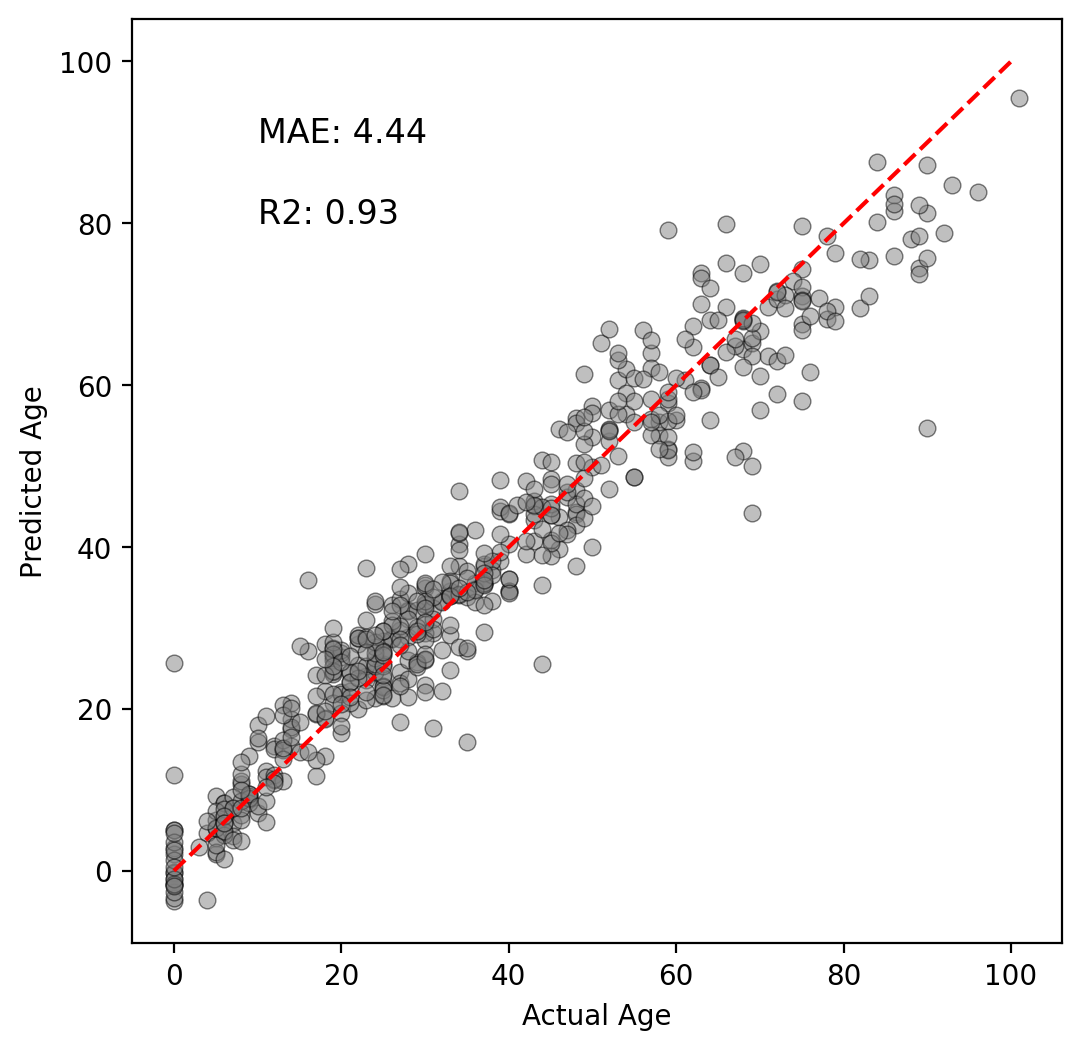

In [20]:
model_path = MODELS_PATH / "elastic_net_27k.npz"
if not model_path.exists():
    samples, X_27k, y_27k = load_samples(PATH_27K, geo_samples_age_map_27k)
    model_27k, y_test_27k, y_pred_27k = train_elastic_net(X_27k, y_27k)
    save_model(model_27k, model_path)
    save_model_eval(model_path, y_test_27k, y_pred_27k)
else:
    model_27k = load_model(model_path)
    y_test_27k, y_pred_27k = load_model_eval(model_path)

plot_model_resuts(y_test_27k, y_pred_27k)

## Unhealthy samples age prediction

In [21]:
unhealthy_samples, unhealthy_arr_27k, unhealthy_ages_27k = load_samples(PATH_27K, geo_samples_age_map_27k_unhealthy)

# Predict age for unhealthy samples using model_27k
unhealthy_ages_pred_27k = model_27k.predict(unhealthy_arr_27k)

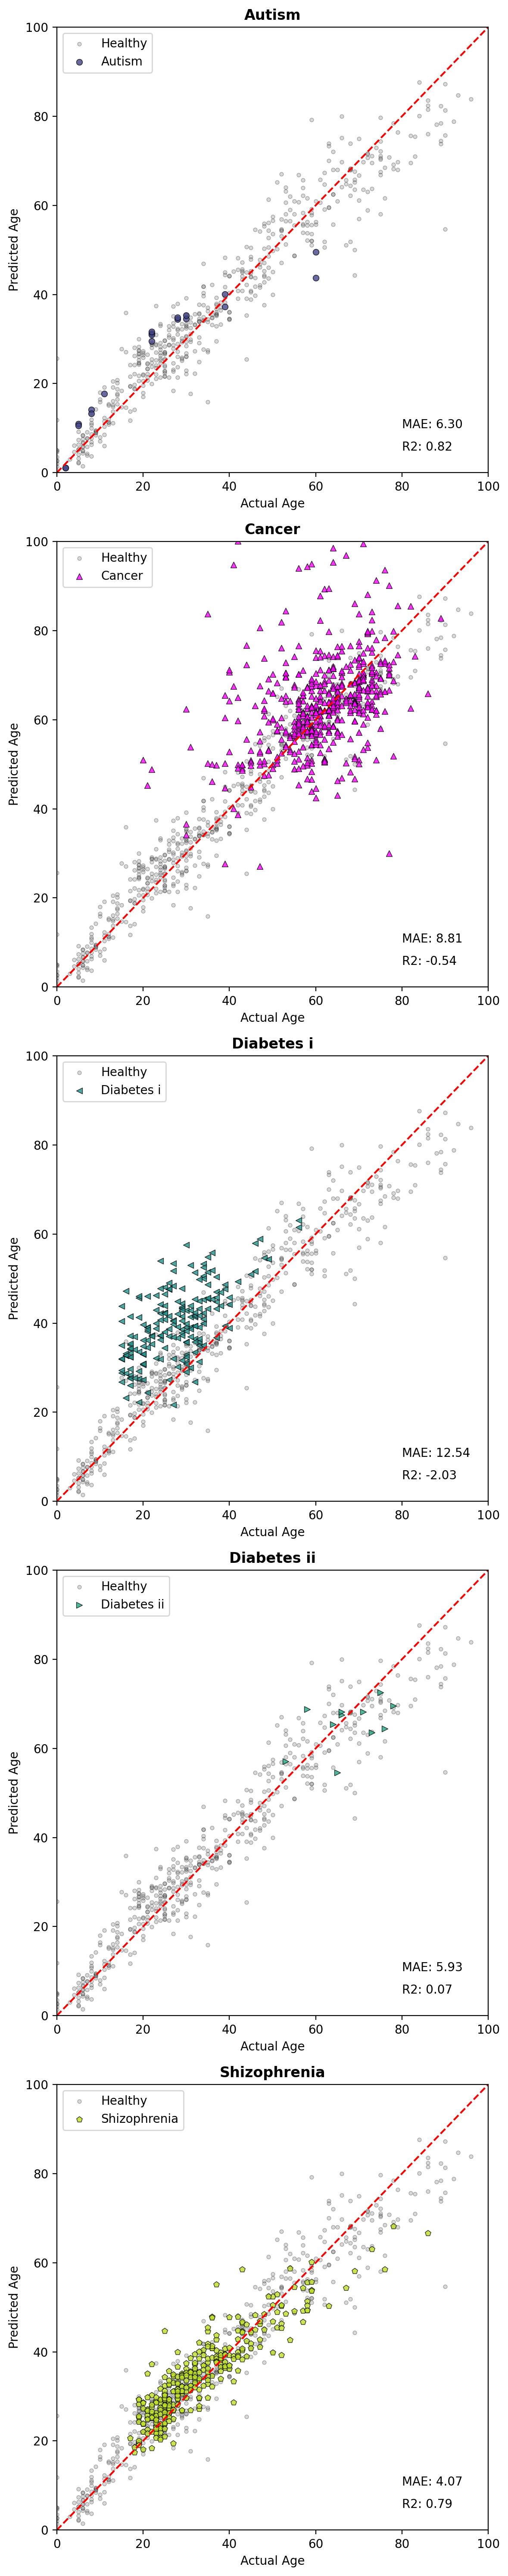

In [22]:
# Count how many diseases you need to plot
d_v_counts_27k = geo_samples_27k_unhealthy['disease'].value_counts()
d_v_counts_27k = d_v_counts_27k[d_v_counts_27k > 10]
num_diseases = sum(1 for disease in colors_dict.keys() if disease != 'healthy' and d_v_counts_27k.get(disease) is not None)

# Dynamically create the subplots
fig, axes = plt.subplots(num_diseases, 1, figsize=(6, 30), dpi=200)
axes = axes.flatten()  # Ensure axes is always a flat array

# Now iterate over the diseases
i = 0
for disease, color in colors_dict.items():
    if disease == 'healthy' or d_v_counts_27k.get(disease) is None:
        continue

    axes[i].scatter(
        y_test_27k,
        y_pred_27k,
        alpha=0.3,
        s=10,
        color=colors_dict['healthy'],
        edgecolors='black',
        linewidths=0.5
    )

    current_disease_ages = []
    current_disease_ages_pred = []
    for sample in unhealthy_samples:
        if disease_map[sample] == disease:
            current_disease_ages.append(geo_samples_age_map_27k_unhealthy[sample])
            current_disease_ages_pred.append(unhealthy_ages_pred_27k[unhealthy_samples.index(sample)])
    current_disease_ages = np.array(current_disease_ages)
    current_disease_ages_pred = np.array(current_disease_ages_pred)
    
    mae = mean_absolute_error(current_disease_ages, current_disease_ages_pred)
    r2 = r2_score(current_disease_ages, current_disease_ages_pred)

    axes[i].scatter(
        current_disease_ages,
        current_disease_ages_pred,
        color=color,
        alpha=0.8,
        s=25,
        marker=markers_dict[disease],
        edgecolors='black',
        linewidths=0.5
    )
    axes[i].set_title(disease.capitalize(), fontsize=12, fontweight='bold')
    axes[i].plot([0, 100], [0, 100], color="red", linestyle="--")
    axes[i].set_xlim(0, 100)
    axes[i].set_ylim(0, 100)
    axes[i].set_xlabel("Actual Age")
    axes[i].set_ylabel("Predicted Age")
    
    # Add legend
    axes[i].scatter(
        [],
        [],
        color=colors_dict['healthy'],
        marker='o',
        linestyle='None',
        label='Healthy',
        alpha=0.3,
        s=10,
        edgecolors='black',
        linewidths=0.5
    )
    axes[i].scatter(
        [],
        [],
        color=color,
        marker=markers_dict[disease],
        linestyle='None',
        label=disease.capitalize(),
        alpha=0.8,
        s=25,
        edgecolors='black',
        linewidths=0.5
    )
    axes[i].legend(loc='upper left')
    
    # Add MAE and R2 to the plot
    axes[i].text(80, 10, f"MAE: {mae:.2f}", fontsize=10)
    axes[i].text(80, 5, f"R2: {r2:.2f}", fontsize=10)

    i += 1  # Increment index

plt.tight_layout()
plt.show()

## Stem cells age prediction

In [23]:
cells_27k_samples, cells_27k_arrays = load_samples_cells(Path("data/arrays_27k_cells"))
cells_27k_pred = model_27k.predict(cells_27k_arrays)

# Create a DataFrame with sample names and predicted ages
cells_27k_df = pd.DataFrame({
    "Sample": cells_27k_samples,
    "Predicted Age": cells_27k_pred
})

# Map samples on the geo_samples_cells DataFrame cell type
cells_27k_df['cell_type'] = cells_27k_df['Sample'].map(geo_samples_cells.set_index("Sample")["cell_type"])
cells_27k_df

Sample  Predicted Age cell_type
0    GSM760354      -5.588405      iPSC
1    GSM760346      -1.528762      iPSC
2    GSM760363      -3.126511      iPSC
3    GSM760334       0.892062      iPSC
4    GSM760257      -4.972743       ESC
..         ...            ...       ...
183  GSM760355     -10.545883      iPSC
184  GSM760229       7.823094       ESC
185  GSM760322      -2.154687      iPSC
186  GSM760367      -1.524768      iPSC
187  GSM760292       2.410667       ESC

[188 rows x 3 columns]

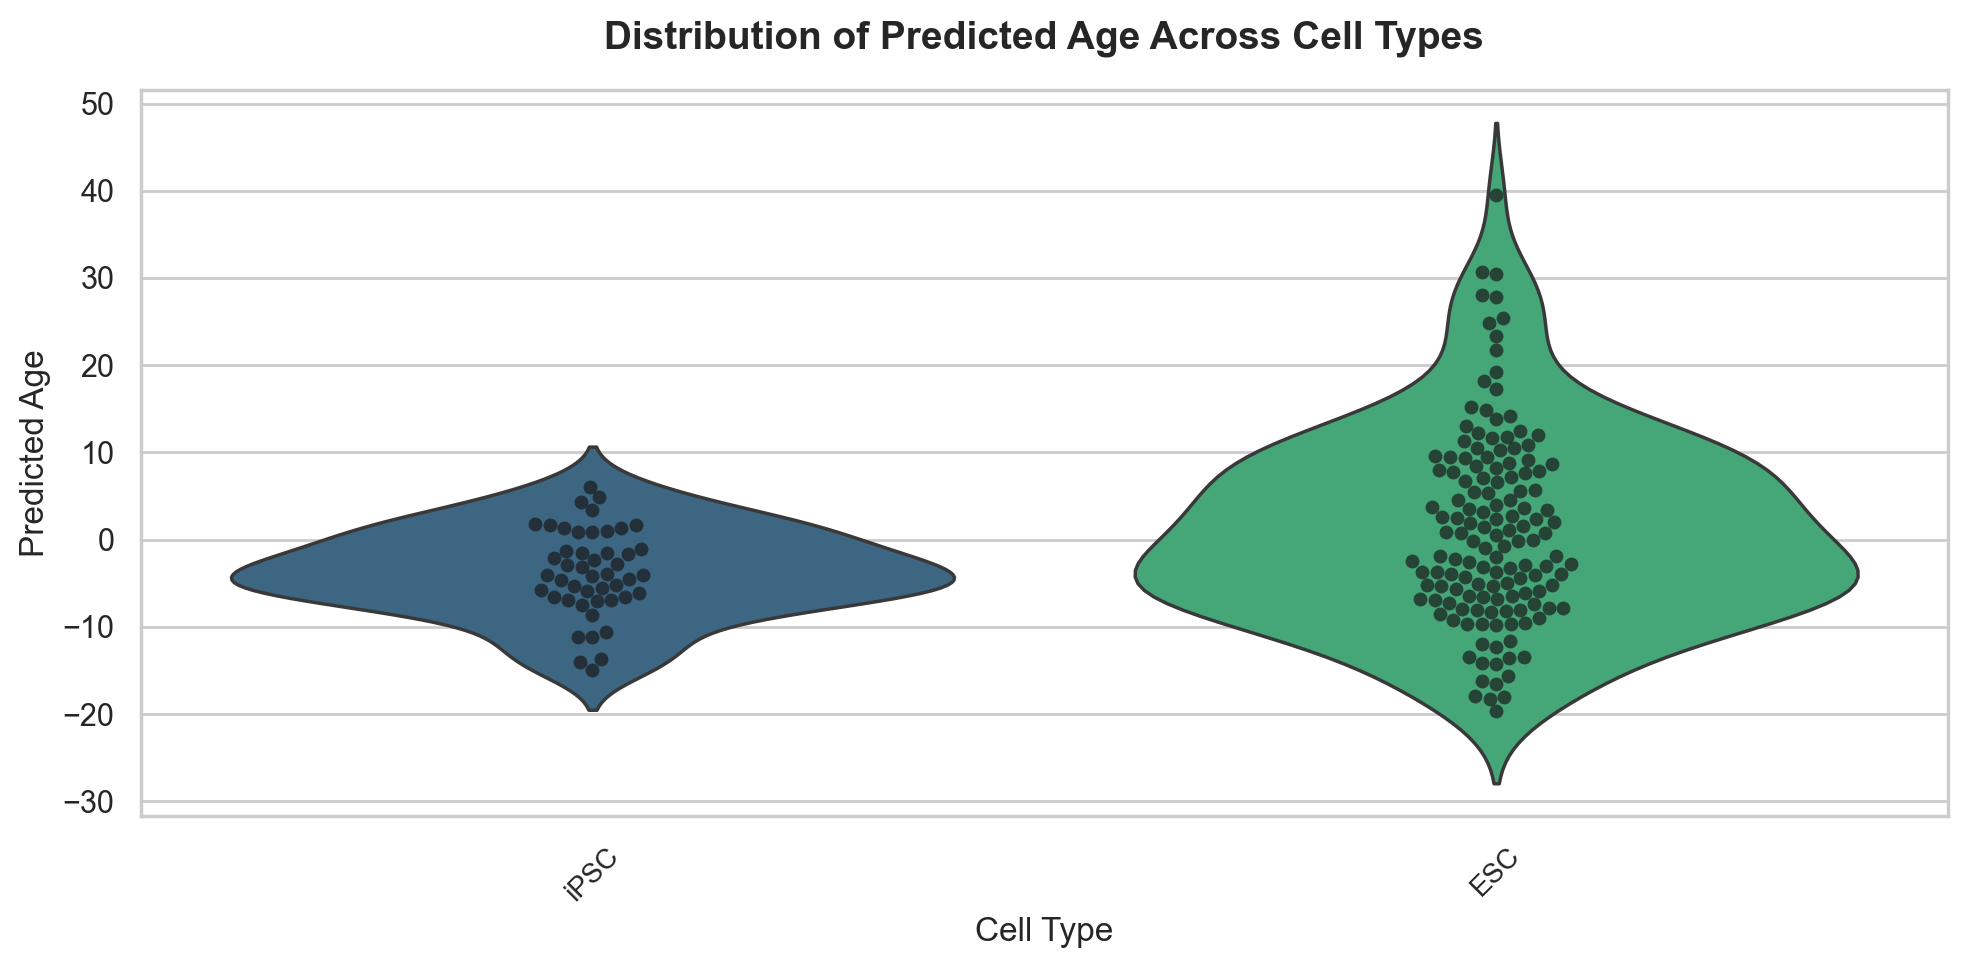

In [24]:
# Enhanced Violin Plot with Swarmplot
plt.figure(figsize=(10, 5), dpi=200)
sns.set_theme(style="whitegrid")  # Cleaner background

# Violin plot
sns.violinplot(
    data=cells_27k_df, 
    x='cell_type', 
    y='Predicted Age', 
    palette='viridis', 
    hue='cell_type',
    inner=None  # Removes inner lines for cleaner plot
)

# Overlay swarmplot to show individual points
sns.swarmplot(
    data=cells_27k_df, 
    x='cell_type', 
    y='Predicted Age', 
    color='k',
    size=5,
    alpha=0.7
)

# Improve labels and title
plt.title("Distribution of Predicted Age Across Cell Types", fontsize=14, pad=15, fontweight='bold')
plt.xlabel("Cell Type", fontsize=12)
plt.ylabel("Predicted Age", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


## Tissue Specific Clocks

In [25]:
geo_samples_27k['tissue'].value_counts()

tissue
blood          1501
brain           523
saliva          281
uterus          152
prostate         70
liver            57
breast           23
bone marrow      16
skin             15
muscle           11
Name: count, dtype: int64

In [26]:
geo_samples_27k_unhealthy['tissue'].value_counts()

tissue
blood       795
breast      114
prostate     85
liver        57
brain        19
muscle       11
Name: count, dtype: int64

In [27]:
SELECTED_TISSUES = [
    'blood',
    'brain',
    'prostate'
]

Training model for blood tissue


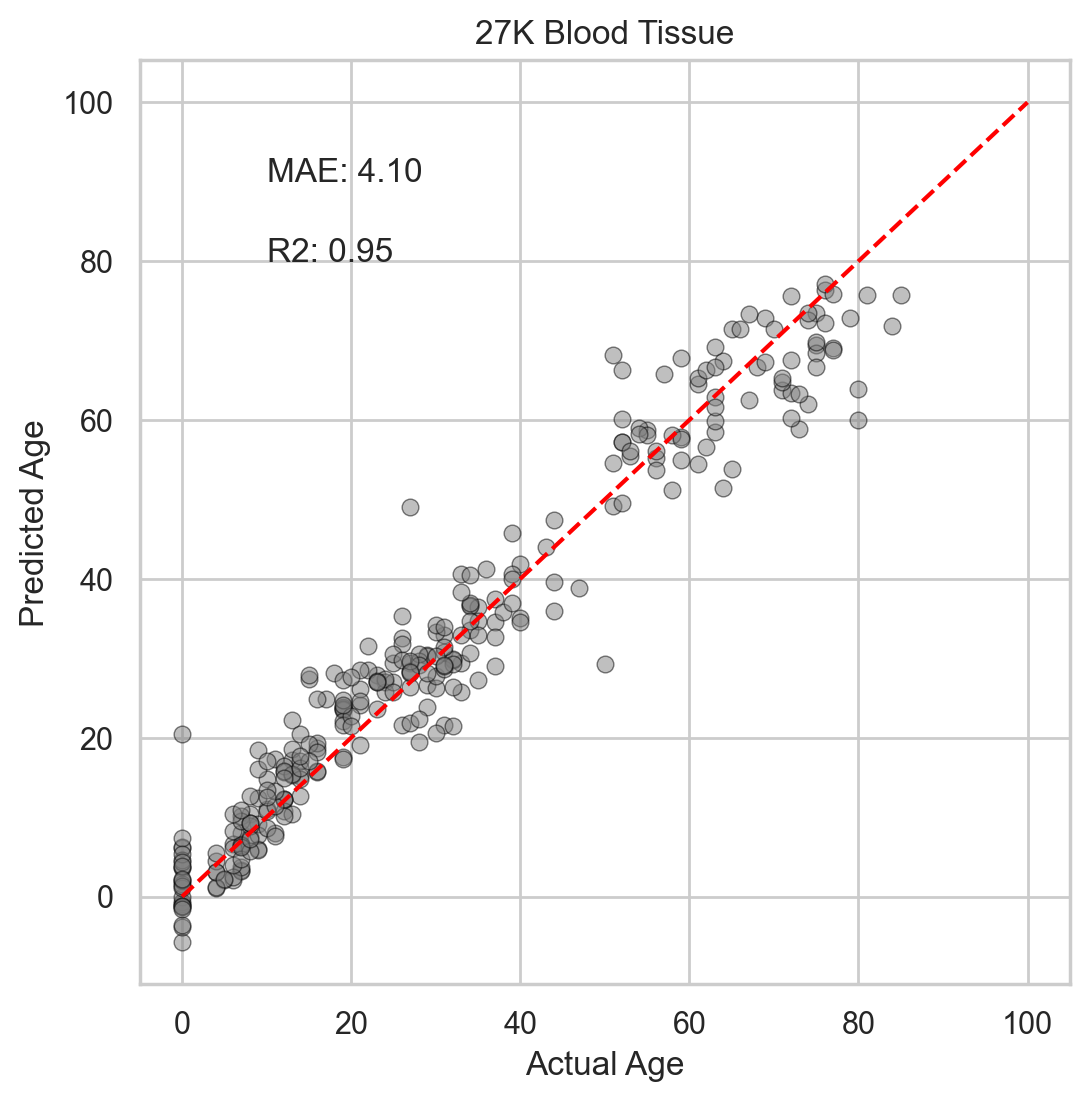

Training model for brain tissue


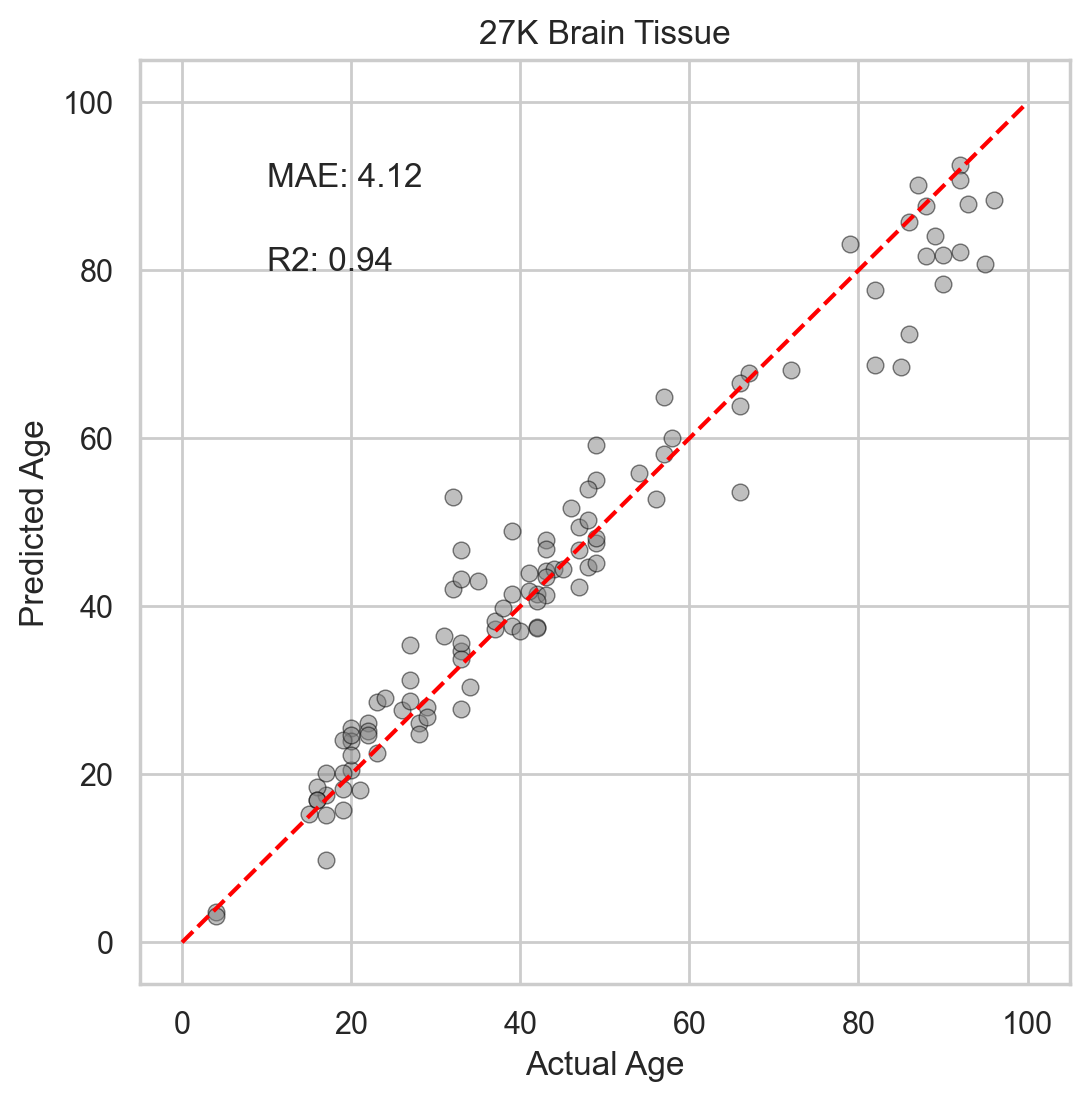

Training model for prostate tissue


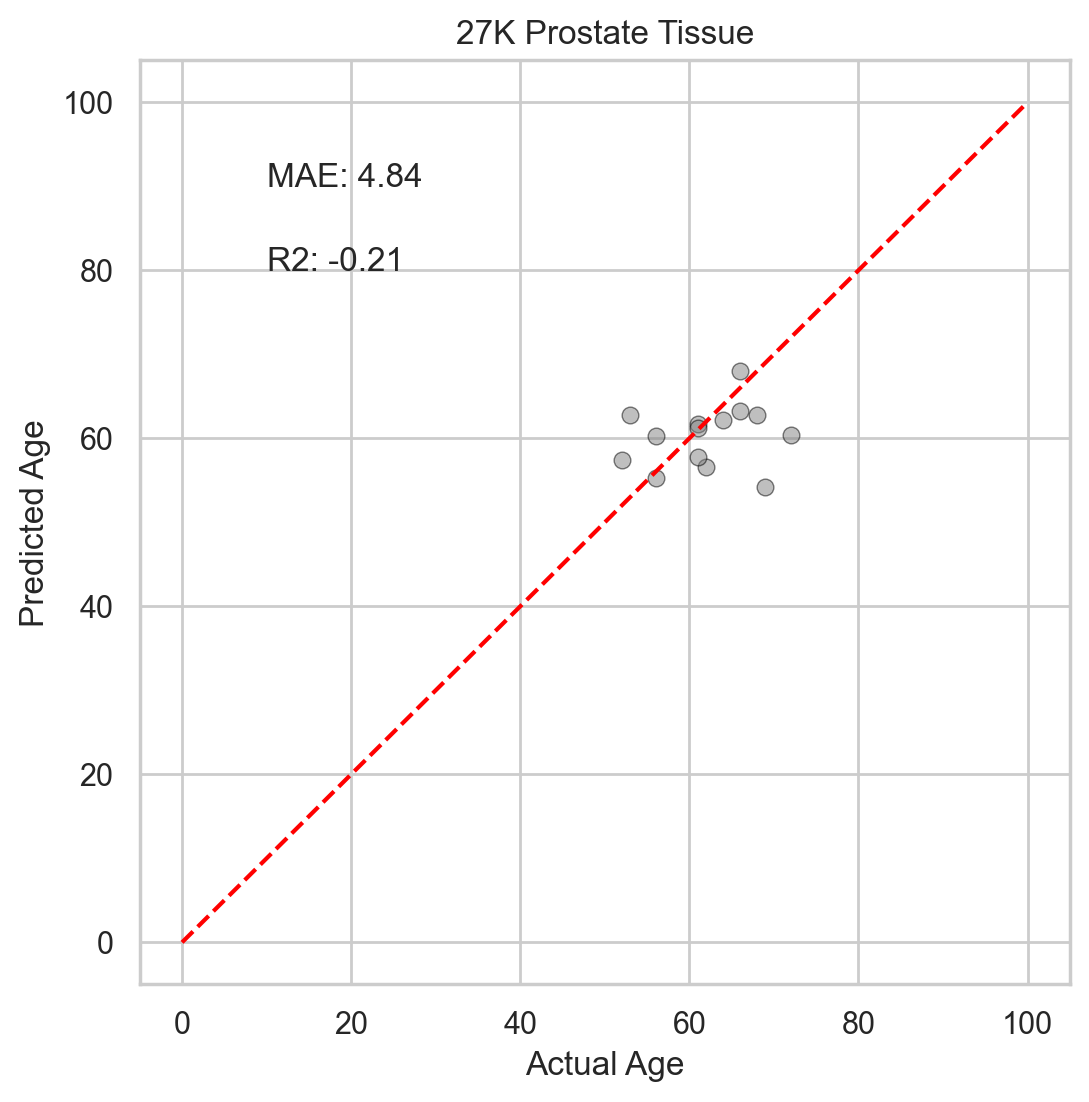

In [28]:
MODELS_27K_DICT = {}
for tissue in SELECTED_TISSUES:
    print(f"Training model for {tissue} tissue")
    model_path = MODELS_PATH / f"elastic_net_27k_{tissue}.npz"
    if not model_path.exists():
        geo_samples_age_map_27k_tissue = geo_samples_27k[geo_samples_27k['tissue'] == tissue].set_index("Sample")["age"].to_dict()
        samples_tissue, X_27k_tissue, y_27k_tissue = load_samples(PATH_27K, geo_samples_age_map_27k_tissue)
        model_27k_tissue, y_test_27k_tissue, y_pred_27k_tissue = train_elastic_net(X_27k_tissue, y_27k_tissue)
        save_model(model_27k_tissue, model_path)
        save_model_eval(model_path, y_test_27k_tissue, y_pred_27k_tissue)
    else:
        model_27k_tissue = load_model(model_path)
        y_test_27k_tissue, y_pred_27k_tissue = load_model_eval(model_path)

    plot_model_resuts(y_test_27k_tissue, y_pred_27k_tissue, title=f"27K {tissue.capitalize()} Tissue")
    MODELS_27K_DICT[tissue] = model_27k_tissue

## Analyze important CpG sites

In [29]:
# Select best 20 CpGs based on the coefficients. Use cpg_27k_meta to get the CpG names
cpgs_27k_meta['coef'] = model_27k.coef_
cpgs_27k_meta['abs_coef'] = np.abs(model_27k.coef_)
top_cpgs_27k = cpgs_27k_meta.sort_values('abs_coef', ascending=False).head(10)
top_cpgs_27k[['abs_coef', 'Symbol']]

abs_coef   Symbol
22694  4.160080   NHLRC1
20646  3.441716     FZD9
27149  3.007009   TOM1L1
19927  2.853809  B3GALT6
22774  2.765783    RPL31
6100   2.714410    PIPOX
23088  2.689226     CBX7
23657  2.589728   PDLIM2
21218  2.587248    CLIC2
13395  2.562557    DSCR6

In [41]:
gene_list = list(set(top_cpgs_27k['Symbol']))
gene_list = [g.upper() for g in gene_list]
print(gene_list)
enr = enrichr(
    gene_list=gene_list,
    gene_sets=['MSigDB_Hallmark_2020', 'KEGG_2021_Human'],
    organism='human',
    outdir=None,
)

enr.results[enr.results['Adjusted P-value'] < 0.05]

['B3GALT6', 'FZD9', 'PDLIM2', 'RPL31', 'NHLRC1', 'TOM1L1', 'PIPOX', 'CLIC2', 'CBX7', 'DSCR6']


Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes]
Index: []

In [72]:
' '.join(gene_list)

'B3GALT6 FZD9 PDLIM2 RPL31 NHLRC1 TOM1L1 PIPOX CLIC2 CBX7 DSCR6'

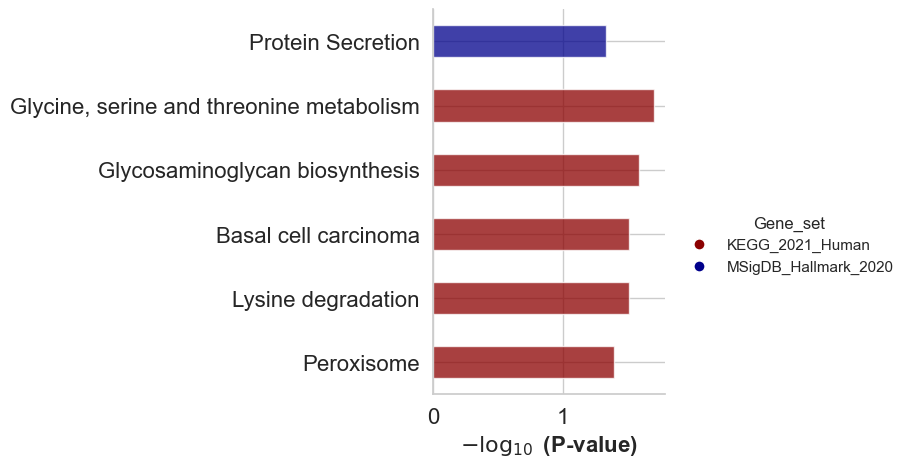

In [ ]:
# categorical scatterplot
ax = barplot(
    enr.results,
    column='P-value',
    group='Gene_set',
    size=10,
    top_term=5,
    figsize=(3,5),
    color = {'KEGG_2021_Human': 'darkred', 'MSigDB_Hallmark_2020':'darkblue'}
)

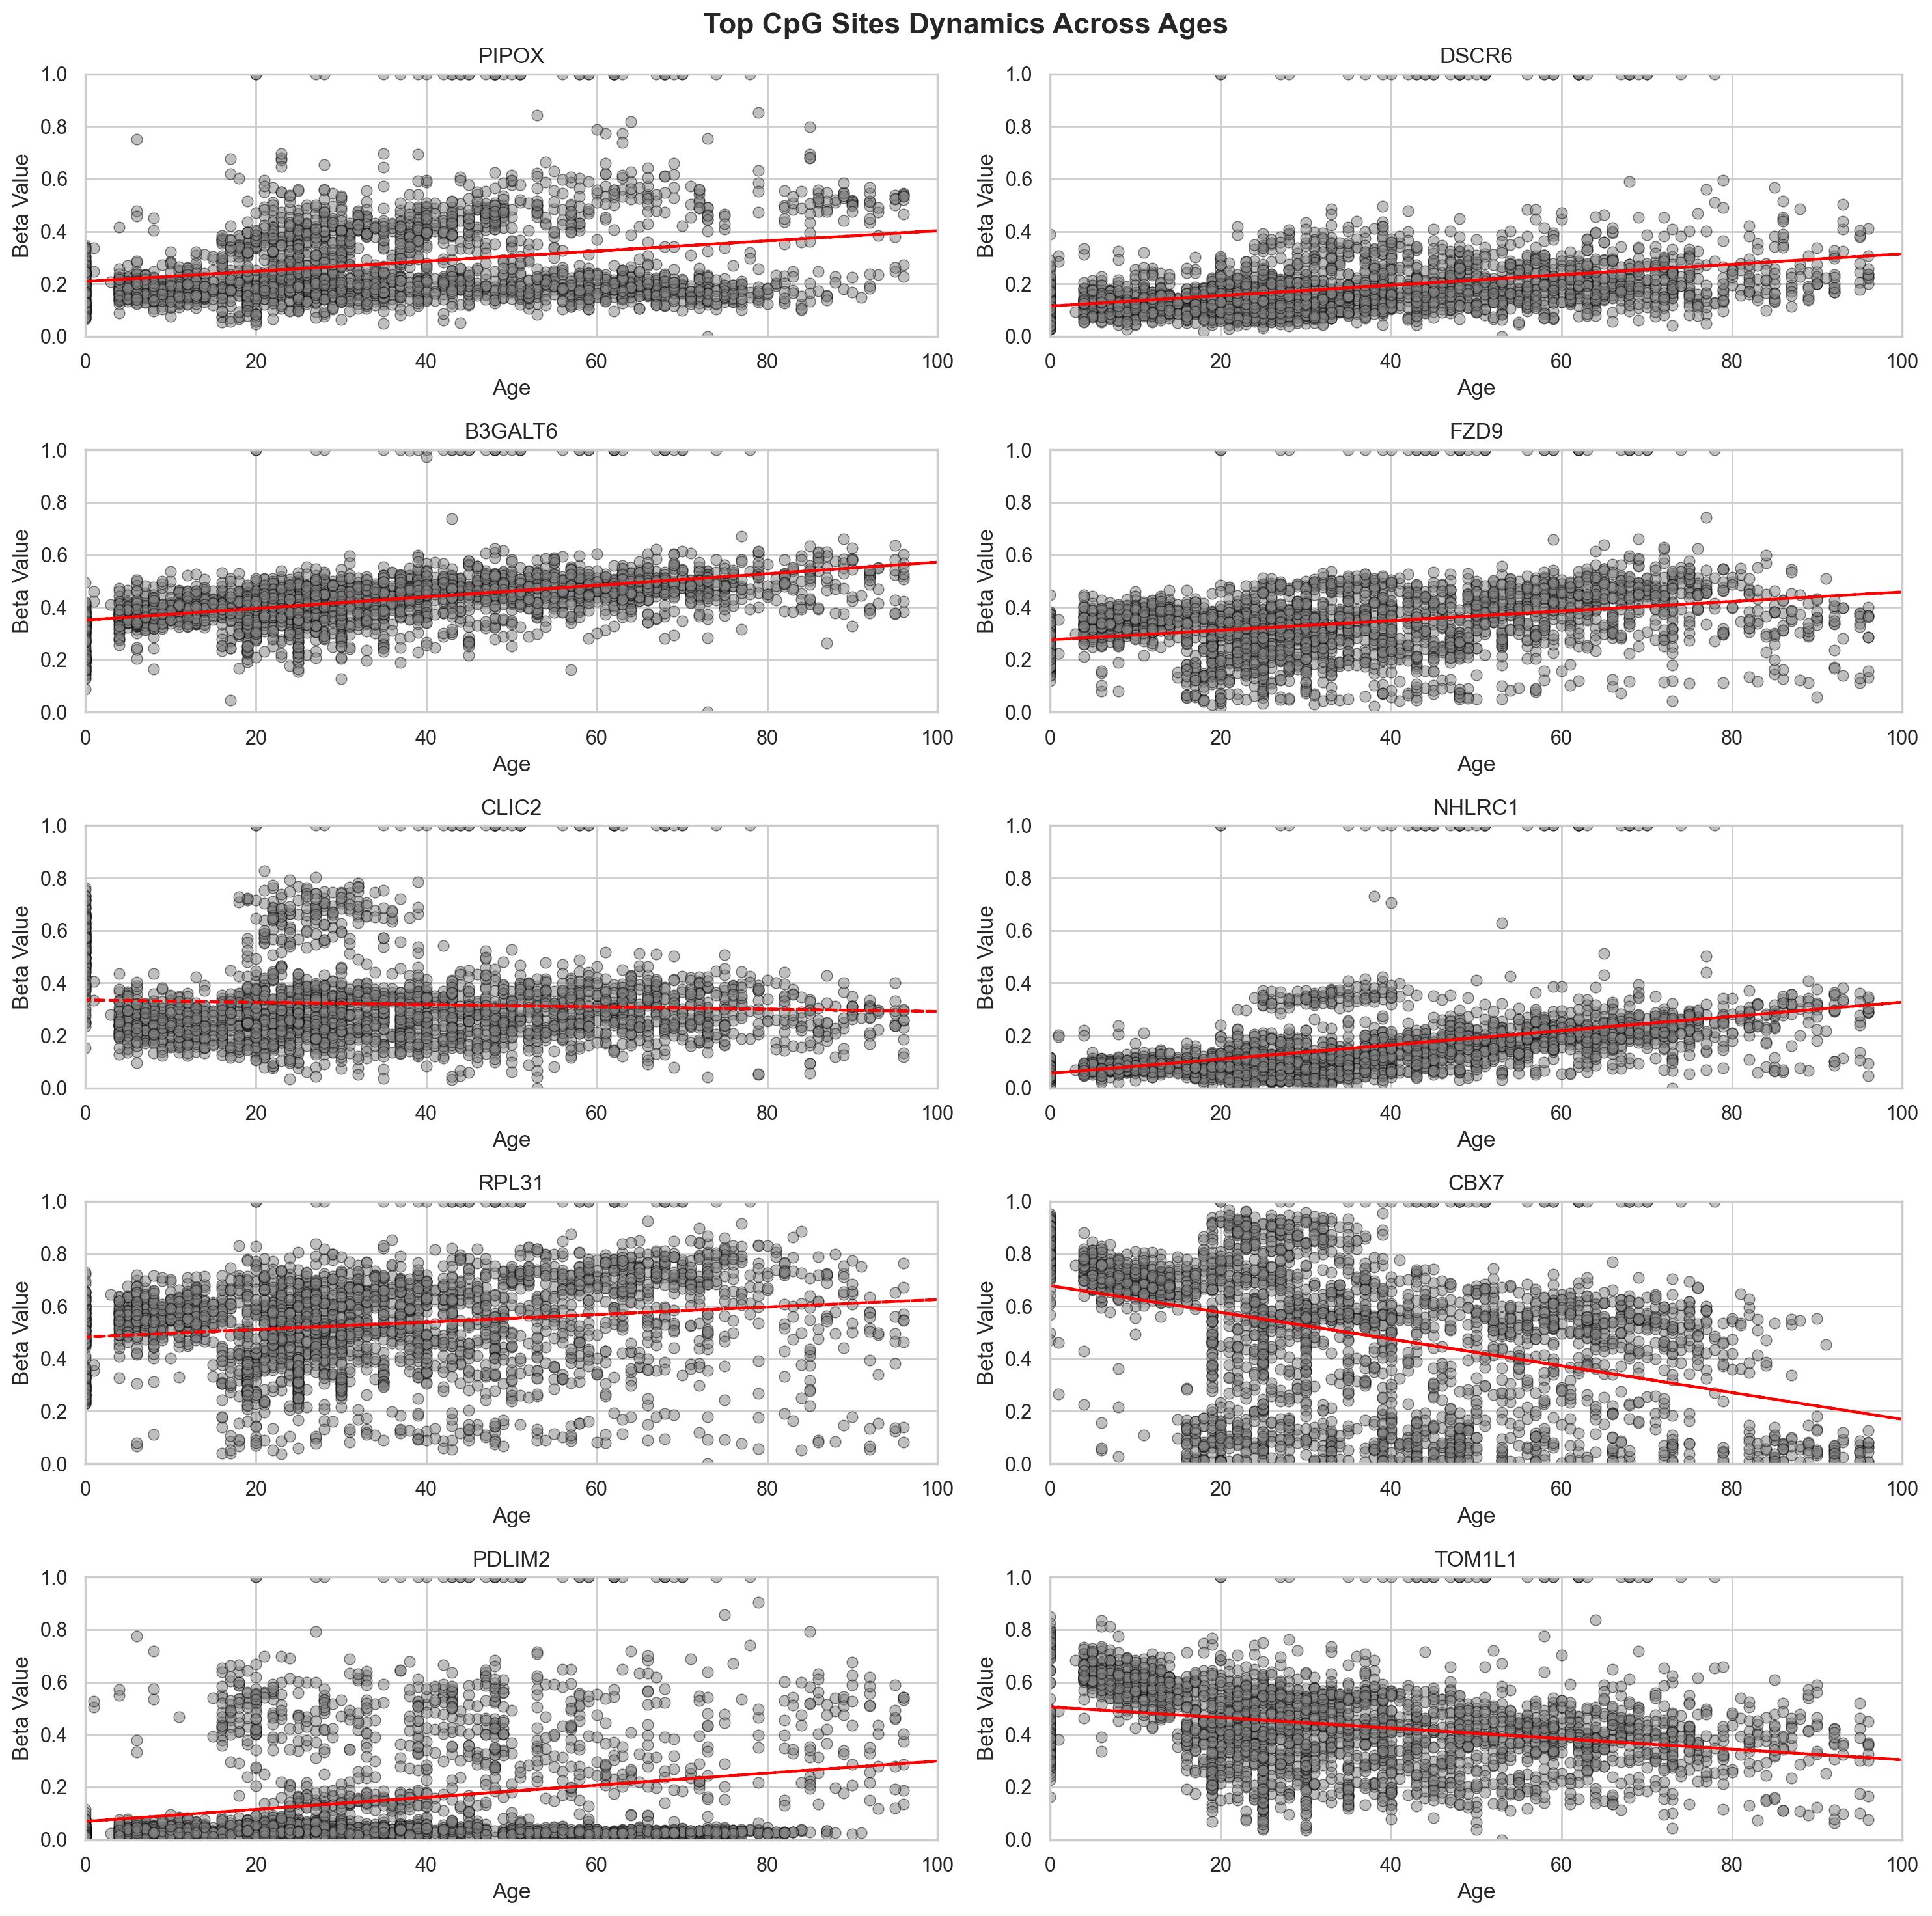

In [79]:
# Look at top CpG sites changes of dynamics across the ages
top_cpgs_indexes = cpgs_27k_meta[cpgs_27k_meta['ID'].isin(top_cpgs_27k['ID'])].index

# Build matrix based on the top CpGs
rows = []
ages = []
samples = []
for file_path in Path('data/arrays_27k').glob("*.npy"):
    sample = file_path.stem
    
    if geo_samples_age_map_27k.get(sample) is None:
        continue

    row = np.load(file_path)
    if np.all(np.isnan(row)):
        continue
    row = np.nan_to_num(row, nan=np.nanmean(row))
    
    # Normalize the data between 0 and 1
    row = (row - np.nanmin(row)) / (np.nanmax(row) - np.nanmin(row))

    # Select only the top CpGs
    row = row[top_cpgs_indexes]
    
    rows.append(row)
    ages.append(geo_samples_age_map_27k[sample])
    samples.append(sample)

rows = np.array(rows)
ages = np.array(ages)


# Plot dynamics of each CpG site across the ages
fig, axes = plt.subplots(5, 2, figsize=(15, 15), dpi=200)
axes = axes.flatten()

# Big Title
fig.suptitle("Top CpG Sites Dynamics Across Ages", fontsize=16, fontweight='bold')

for i, cpg_index in enumerate(top_cpgs_indexes):
    axes[i].scatter(
        ages,
        rows[:, i],
        alpha=0.5,
        color=colors_dict['healthy'],
        edgecolors='black',
        linewidths=0.5
    )
    axes[i].set_title(cpgs_27k_meta.loc[cpg_index, 'Symbol'])
    axes[i].set_xlabel("Age")
    axes[i].set_ylabel("Beta Value")
    axes[i].set_xlim(0, 100)
    axes[i].set_ylim(0, 1)
    
    # Linear regression
    model = ElasticNet(alpha=0.01, l1_ratio=0.05, max_iter=2000)
    model.fit(ages.reshape(-1, 1), rows[:, i])
    y_pred = model.predict(ages.reshape(-1, 1))
    axes[i].plot(ages, y_pred, color='red', linestyle='--')
    
plt.tight_layout()

plt.show()

# 450K model

## Train the model

/home/dglubokov/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.398e+02, tolerance: 2.597e+01
  model = cd_fast.enet_coordinate_descent(


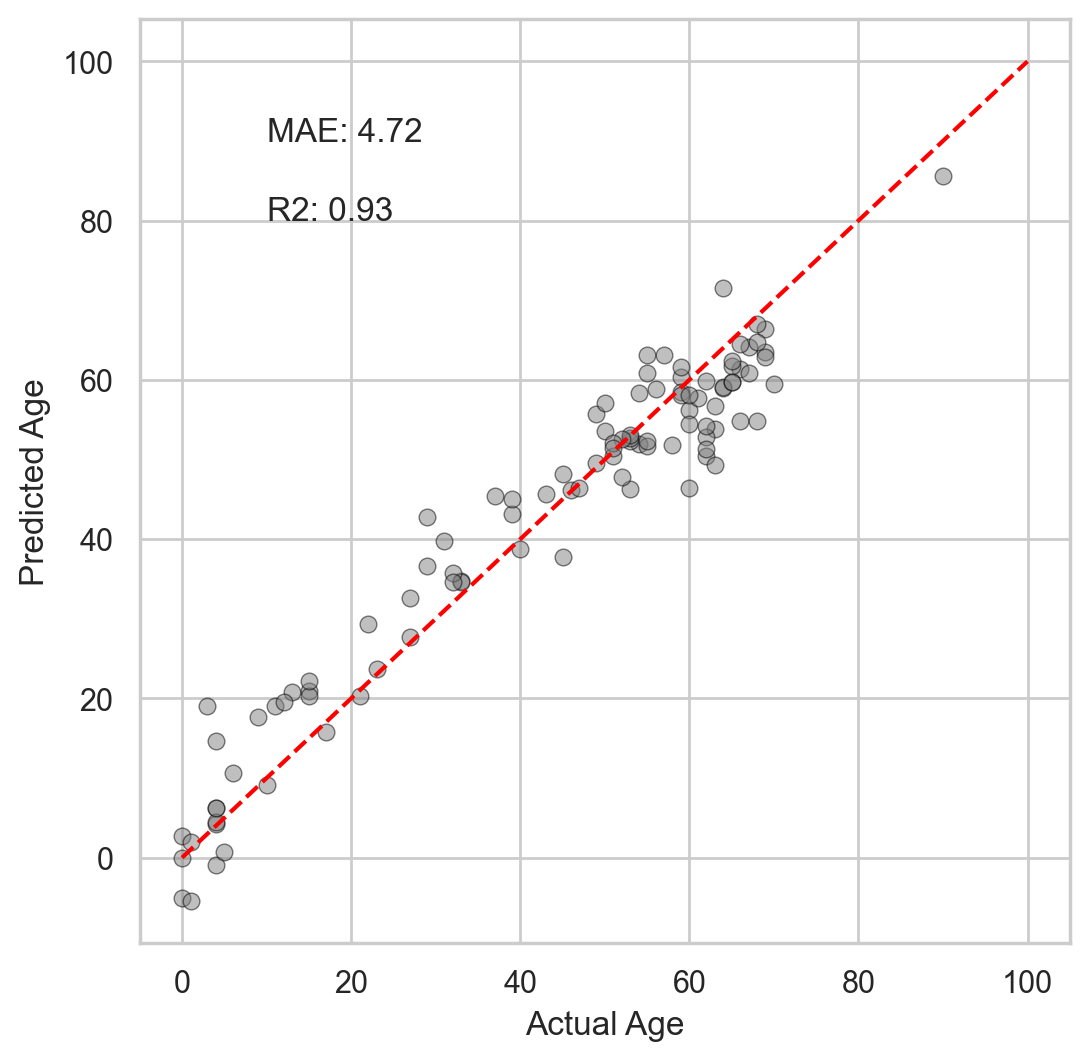

In [25]:
model_path = MODELS_PATH / "elastic_net_450k.npz"
if not model_path.exists():
    samples, X_450k, y_450k = load_samples(PATH_450K, geo_samples_age_map_450k)
    model_450k, y_test_450k, y_pred_450k = train_elastic_net(X_450k, y_450k)
    save_model(model_450k, model_path)
    save_model_eval(model_path, y_test_450k, y_pred_450k)
else:
    model_450k = load_model(model_path)
    y_test_450k, y_pred_450k = load_model_eval(model_path)

plot_model_resuts(y_test_450k, y_pred_450k)